### Pipeline for a single spikeglx session
- Load an exctractor for visualization of the data
- Sort it using kilosort

In [1]:
%matplotlib inline

import os
import glob
import logging
import numpy as np
from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)


os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["KILOSORT_PATH"] = '/mnt/cube/earneodo/repos/Kilosort'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'

In [2]:
from ceciestunepipe.file import filestructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

In [3]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2021-01-08 07:33:48,041 root         INFO     all modules loaded


### Session parameters and raw files

In [4]:
reload(et)

bci_locations_dict = {'mnt': os.path.abspath('/mnt/cube/earneodo/bci_zf/neuropix/birds'),
                             'local': os.path.abspath('/mnt/cube/earneodo/scratch/raw_data'),
                             'fast': os.path.abspath('/mnt/cube/earneodo/scratch')
                             }

bird = 'z_w12m7_20'
all_bird_sess = et.list_sessions(bird, location_dict=bci_locations_dict)
all_bird_sess

['20201105', '20201106', '20201104']

In [5]:
sess_par = {'bird': 'z_w12m7_20',
           'sess': '20201104',
           'probe': 'probe_0', # probe to sort ('probe_0', 'probe_1') (to lookup in the rig_par which port to extract)
           'sort': 2}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sess_par['sort'],
                              location_dict=bci_locations_dict)

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['raw']

In [6]:
sess_epochs = sglu.list_sgl_epochs(sess_par, location_dict=bci_locations_dict)
sess_epochs

2021-01-08 07:33:50,659 ceciestunepipe.util.sglxutil INFO     {'folders': {'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20', 'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104', 'kwik': '/mnt/cube/earneodo/scratch/raw_data/z_w12m7_20/Ephys/kwik/20201104', 'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104', 'msort': '/mnt/cube/earneodo/scratch/z_w12m7_20/Ephys/msort/20201104', 'ksort': '/mnt/cube/earneodo/scratch/z_w12m7_20/Ephys/ksort/20201104'}, 'files': {'par': '/mnt/cube/earneodo/scratch/z_w12m7_20/Ephys/ksort/20201104/params.json', 'set': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/settings.isf', 'rig': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/rig.json', 'kwd': '/mnt/cube/earneodo/scratch/raw_data/z_w12m7_20/Ephys/kwik/20201104/stream.kwd', 'kwik': '/mnt/cube/earneodo/scratch/raw_data/z_w12m7_20/Ephys/kwik/20201104/sort_2/spikes.kwik', 'kwe': 

['20201104_alles',
 '2500r250a_3500_dir_g0',
 '2500r250a_3500_dir_g1',
 '2500r250a_3500_dir_g2']

In [7]:
### pick a session
reload(sglu)
epoch = sess_epochs[-2]

exp_struct = sglu.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['raw'])

In [8]:
sgl_folders

{'nidq': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g1',
 'imec_0': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g1/2500r250a_3500_dir_g1_imec0'}

In [9]:
sgl_files

{'nidq': ['/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g1/2500r250a_3500_dir_g1_t0.nidq.meta'],
 'lf_0': ['/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g1/2500r250a_3500_dir_g1_imec0/2500r250a_3500_dir_g1_t0.imec0.lf.meta'],
 'ap_0': ['/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g1/2500r250a_3500_dir_g1_imec0/2500r250a_3500_dir_g1_t0.imec0.ap.meta']}

In [10]:
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}


#probe_data_folder = sgl_folder['imec'][probe_id]


In [11]:
sglex.SpikeGLXRecordingExtractor?

In [12]:
### view the nidaq data

In [13]:
run_recordings['nidq']

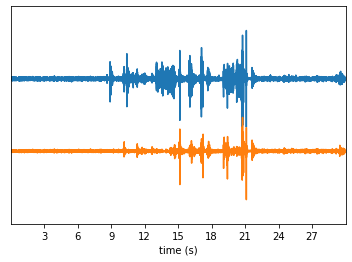

In [14]:
w_ts = sw.plot_timeseries(run_recordings['nidq'], channel_ids=[0, 7], trange=[0,30])

In [15]:
nidq_ttl = run_recordings['nidq'].get_ttl_events()

In [16]:
run_recordings['lf_0']._raw.shape

(385, 2339386)

In [17]:
import numpy as np


In [18]:
syn_ch_arr = run_recordings['lf_0']._raw[-1, :]

np.mean(syn_ch_arr)

32.00686675905558

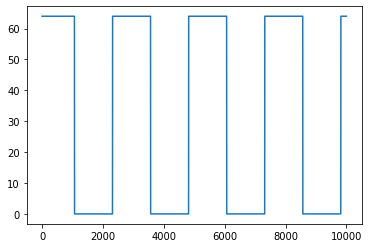

In [31]:
plt.plot(syn_ch_arr[:10000])

In [23]:
run_1recordings['nidq']._meta

{'acqMnMaXaDw': '0,0,8,1',
 'appVersion': '20200520',
 'fileCreateTime': '2020-11-04T17:46:52',
 'fileName': 'D:/experiment/raw_data/z_w12m7_20/20201104/2500r250a_3500_dir_g1/2500r250a_3500_dir_g1_t0.nidq.bin',
 'fileSHA1': 'A0B2FC5E2E55E8FDB87DD650C3D567E861CDF8D3',
 'fileSizeBytes': '421084818',
 'fileTimeSecs': '935.7555521513954',
 'firstSample': '221538367',
 'gateMode': 'Immediate',
 'nDataDirs': '1',
 'nSavedChans': '9',
 'niAiRangeMax': '5',
 'niAiRangeMin': '-5',
 'niAiTermination': 'RSE',
 'niClockLine1': 'Internal',
 'niClockSource': 'PXI1Slot4_8ch_Int : 25000.000000',
 'niDev1': 'PXI1Slot4',
 'niDev1ProductName': 'PXIe-6363',
 'niMAChans1': '',
 'niMAGain': '1',
 'niMNChans1': '',
 'niMNGain': '200',
 'niMuxFactor': '32',
 'niSampRate': '24999.692437',
 'niStartEnable': 'false',
 'niStartLine': 'PXI1Slot4/port0/line0',
 'niXAChans1': '0:7',
 'niXDBytes1': '1',
 'niXDChans1': '0:7',
 'snsMnMaXaDw': '0,0,8,1',
 'snsSaveChanSubset': 'all',
 'syncNiChan': '0',
 'syncNiChanType'

## The digital and sync channel in the recording
- using the new methods in my version of readSGLX, spikeglxrecordingextractor

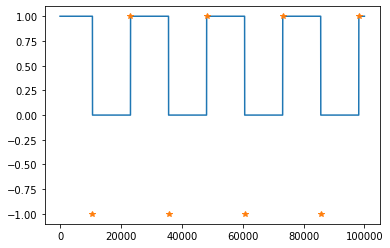

In [23]:
### the digital chan and the syn extraction of the nidq rec

nidq_syn = rsgl.ExtractDigital(run_recordings['nidq']._raw, 0, 100000, 0, [0], run_recordings['nidq']._meta)
nidq_syn_ttl = run_recordings['nidq'].get_ttl_events(channel_id=0, end_frame=100000)

plt.plot(nidq_syn.flatten())
plt.plot(*nidq_syn_ttl, '*')

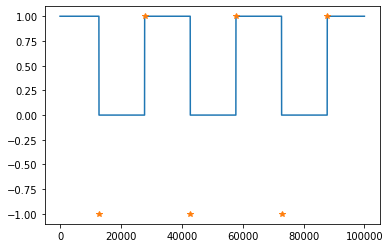

In [26]:
### the digital chan and the syn extraction of the nidq rec
ap_syn = rsgl.ExtractDigital(run_recordings['ap_0']._raw, 0, 100000, 0, [0], run_recordings['ap_0']._meta)
ap_syn_ttl = run_recordings['ap_0'].get_ttl_events(end_frame=100000)

plt.plot(ap_syn.flatten())
plt.plot(*ap_syn_ttl, '*')

In [29]:
ttl_arr = np.array(ap_syn_ttl)

In [35]:
ttl_arr[1]==-1

array([ True, False,  True, False,  True, False])

In [39]:
np.diff(ttl_arr[0, ttl_arr[1]==-1])

array([30000, 30000])

### The time syncronization

In [42]:
def compute_sf(ttl: tuple):
    ttl_arr = np.array(ttl)
    
    # get all the diffs betwenn edge ups and edge donws
    all_diff_arr = np.concatenate([np.diff(ttl_arr[0, ttl_arr[1]==j]) for j in [-1, 1]])
    
    return all_diff_arr

compute_sf(ap_syn_ttl)

array([30000, 30000, 30000, 30000])

In [ ]:
def compute_sf(recording)
    syn_ttl = recording.get_ttl_events(end_frame=100000)

### The sorting

In [16]:
se.installed_recording_extractor_list

[spikeextractors.extractors.mdaextractors.mdaextractors.MdaRecordingExtractor,
 spikeextractors.extractors.biocamrecordingextractor.biocamrecordingextractor.BiocamRecordingExtractor,
 spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaRecordingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortRecordingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusRecordingExtractor,
 spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor,
 spikeextractors.extractors.phyextractors.phyextractors.PhyRecordingExtractor,
 spikeextractors.extractors.maxoneextractors.maxoneextractors.MaxOneRecordingExtractor,
 spikeextractors.extractors.mea1kextractors.mea1kextractors.Mea1kRecordingExtractor,
 spikeextractors.extractors.mcsh5recordingextractor.mcsh5rec

In [27]:
se.KiloSortRecordingExtractor?